In [1]:
import sys
sys.path.append('/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/raygun/CycleGAN/')
from CycleGun_CBv30nmBottom100um_cb2gcl1_20211101_train import *
import matplotlib.pyplot as plt
import zarr


Importing dependencies...
Loading model...
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
Loaded.


In [3]:
cycleGun.set_device(3)

INFO:gunpowder.torch.nodes.train:Starting training from scratch
INFO:gunpowder.torch.nodes.train:Using device cuda
INFO:gunpowder.nodes.generic_train:Train process: iteration=1 loss=98.841171 time=2.604361


{'loss_D1': 0.8223254084587097, 'loss_D2': 0.626316487789154, 'loss_cycle': 29.971879959106445, 'loss_G1': 33.05679702758789, 'loss_G2': 34.36384963989258}


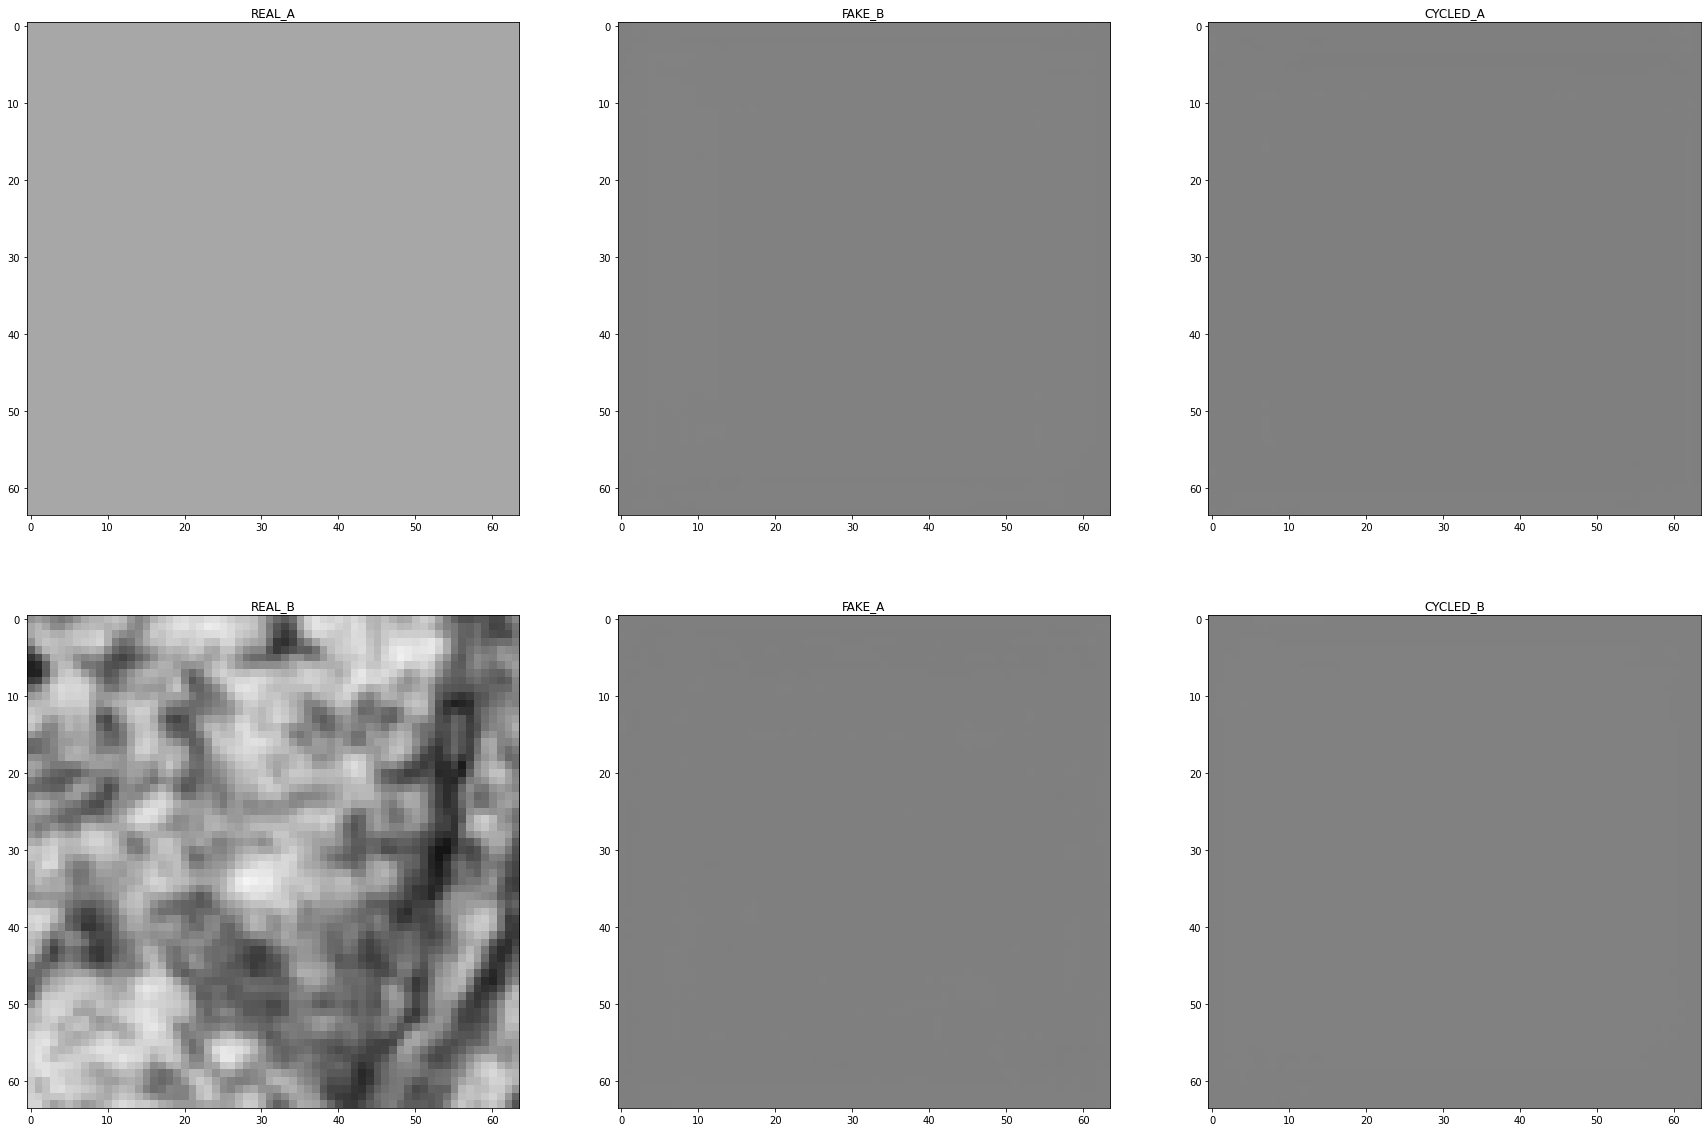

In [2]:
batch = cycleGun.test_train()

INFO:gunpowder.torch.nodes.predict:Predicting on gpu


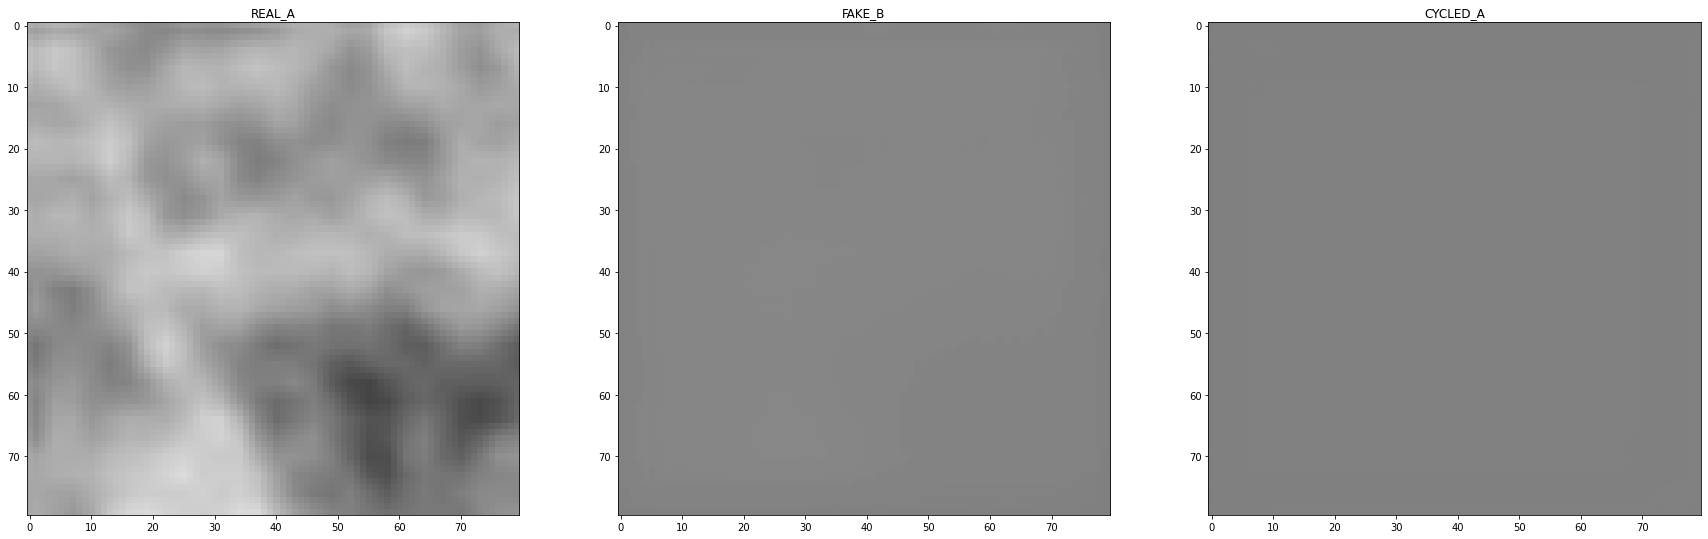

In [4]:
pred_batch = cycleGun.test_prediction('A', side_length=80)

In [12]:
downsample_factors = [(cycleGun.g_downsample_factor,)*cycleGun.ndims,] * (cycleGun.gnet_depth - 1)
kernel_size_down = cycleGun.g_kernel_size_down #<- length of list determines number of conv passes in level
kernel_size_up = cycleGun.g_kernel_size_up

num_levels = len(downsample_factors) + 1
if kernel_size_down is None:
    kernel_size_down = [[(3, 3, 3), (3, 3, 3)]]*num_levels
if kernel_size_up is None:
    kernel_size_up = [[(3, 3, 3), (3, 3, 3)]]*(num_levels - 1)

level_pads = []
#going down
for level in np.arange(cycleGun.gnet_depth - 1):
    level_pads.append(np.sum(np.array(kernel_size_down[level]) - 1, axis=0) * (cycleGun.g_downsample_factor ** level))

#bottom level
level_pads.append(np.sum(np.array(kernel_size_down[-1]) - 1, axis=0) * (cycleGun.g_downsample_factor ** (cycleGun.gnet_depth - 1)))

#coming up
for level in np.arange(cycleGun.gnet_depth - 1)[::-1]:
    level_pads.append(np.sum(np.array(kernel_size_up[level]) - 1, axis=0) * (cycleGun.g_downsample_factor ** level))

padding = gp.Coordinate(np.sum(level_pads, axis=0)) // 2


In [17]:
daisy.Coordinate(gp.Coordinate((30,30,30)))

(30, 30, 30)

In [8]:
pipe = cycleGun.source_A + gp.RandomLocation() + cycleGun.resample_A
req = gp.BatchRequest()
req.add(cycleGun.real_A_src, cycleGun.A_voxel_size * cycleGun.get_extents(), cycleGun.A_voxel_size)
req.add(cycleGun.real_A, cycleGun.common_voxel_size * cycleGun.get_extents(), cycleGun.common_voxel_size)
with gp.build(pipe):
    batch = pipe.request_batch(req)
batch


	REAL_A_SRC: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (90, 90, 90), interpolatable: True, non-spatial: False, dtype: uint8, placeholder: False
	REAL_A: ROI: [960:1920, 960:1920, 960:1920] (960, 960, 960), voxel size: (30, 30, 30), interpolatable: True, non-spatial: False, dtype: float64, placeholder: False

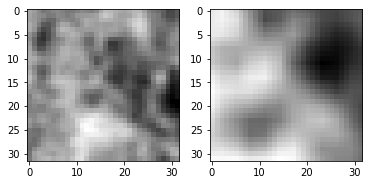

In [10]:
data = batch[cycleGun.real_A_src].data
mid = data.shape[0] // 2
img = data[mid].astype(np.float32)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img, cmap='gray')

data = batch[cycleGun.real_A].data
mid = data.shape[0] // 2
img = data[mid].astype(np.float32)
axs[1].imshow(img, cmap='gray')

In [3]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import daisy

In [ ]:
z = zarr.open('/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/jlr54_tests/volumes/cb2_gcl1.n5')
    # '/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/jlr54_tests/volumes/CBxs_lobV_bottomp100um_30nm_rectwopassdb9_.n5')
im_data = np.array(z['volumes/raw'][400:600, 10000:14000, 10000:14000]).squeeze()
# im = np.array(z['volumes/raw'][1400:1800, 1400:1800, 1400:1800])[200].squeeze()
z['volumes']['raw'].info

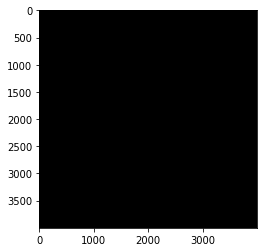

In [8]:
plt.imshow(im_data[55], cmap='gray')

In [4]:
ds = daisy.open_ds('/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/jlr54_tests/volumes/cb2_gcl1.n5', 'volumes/raw')
# ds = daisy.open_ds('/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/jlr54_tests/volumes/CBxs_lobV_bottomp100um_30nm_rectwopassdb9_.n5', 'volumes/raw')
roi = daisy.Roi((2800+22000, 520000+46000, 744000+46000), (40, 4000, 4000))
img = ds.to_ndarray(roi)

In [5]:
ds.voxel_size

(40, 4, 4)

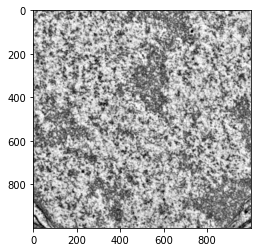

In [6]:
plt.imshow(img[0].squeeze(), cmap='gray')

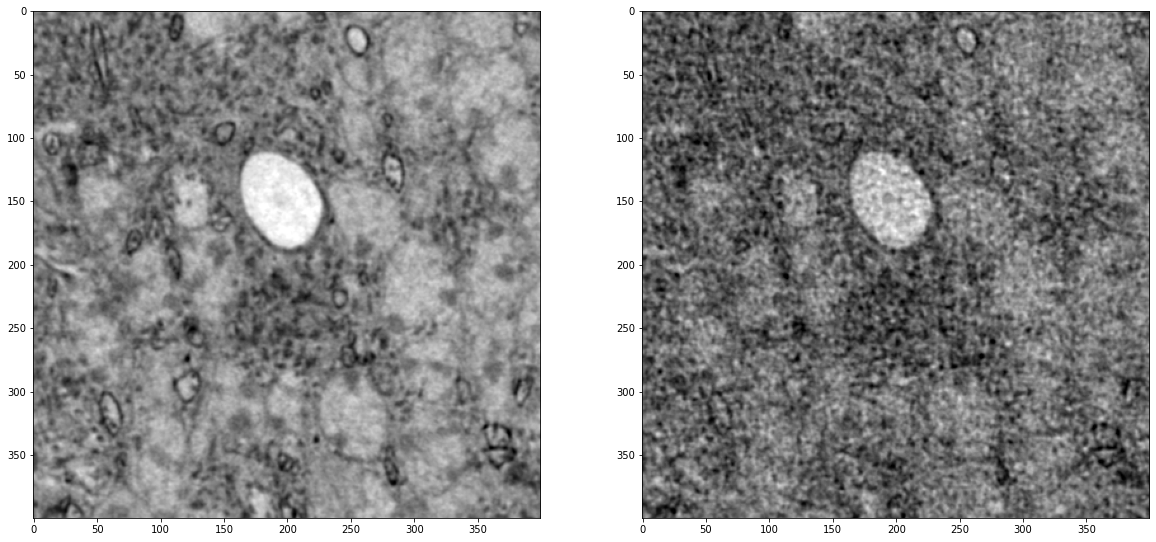

In [27]:
z = zarr.open('/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/jlr54_tests/volumes/CBm_FN_lobX_90nm_tile2_rec_db9_twopass_full_.n5')
y = zarr.open('/n/groups/htem/ESRF_id16a/LTP/cb_FN_lobX_feb2021/volraw/CBm_FN_lobX_90nm_tile2_rec_db9_twopass_full_.n5')

full = np.array(z['volumes']['raw'][1400:1800, 1400:1800, 1400:1800]).squeeze()
quart = np.array(z['volumes']['quarterAngle'][1400:1800, 1400:1800, 1400:1800]).squeeze()
# quart = np.array(z['volumes']['quarterAngle'][1400:1800, 1400:1800, 1400:1800]).squeeze()
# z['volumes']['quarterAngle'].info
# y['volumes']['raw'].info

fig, ax = plt.subplots(1, 2, figsize=(20,40))
ax[0].imshow(full[200,...], cmap='gray')
ax[1].imshow(quart[200,...], cmap='gray')

In [22]:
(quart == full).all()

True

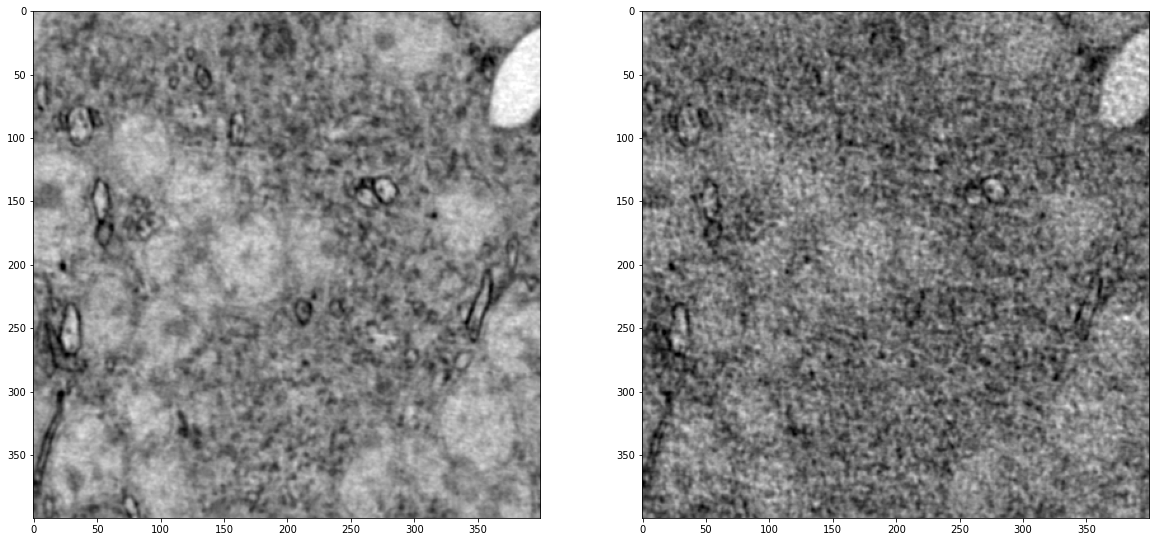

In [23]:
z = zarr.open('/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/jlr54_tests/volumes/CBm_FN_lobX_90nm_tile3_twopass_rec_.n5')
y = zarr.open('/n/groups/htem/ESRF_id16a/LTP/cb_FN_lobX_feb2021/volraw/CBm_FN_lobX_90nm_tile3_twopass_rec_.n5')

full = np.array(z['volumes']['raw'][1400:1800, 1400:1800, 1400:1800]).squeeze()
quart = np.array(z['volumes']['quarterAngle'][1400:1800, 1400:1800, 1400:1800]).squeeze()
# quart = np.array(z['volumes']['quarterAngle'][1400:1800, 1400:1800, 1400:1800]).squeeze()
# z['volumes']['quarterAngle'].info
# y['volumes']['raw'].info

fig, ax = plt.subplots(1, 2, figsize=(20,40))
ax[0].imshow(full[200,...], cmap='gray')
ax[1].imshow(quart[200,...], cmap='gray')

In [39]:
z['volumes']['quarterAngle'].attrs.keys()

dict_keys(['offset', 'resolution'])

In [23]:
z = zarr.open('/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/jlr54_tests/volumes/CBxs_lobX_bottomp100um_30nm_rec_db9_.n5')
im = np.array(z['volumes']['raw'][1400:1800, 1400:1800, 1024]).squeeze()
z['volumes']['raw'].info

Name,/volumes/raw
Type,zarr.core.Array
Data type,uint8
Shape,"(3216, 3216, 2048)"
Chunk shape,"(201, 201, 128)"
Order,C
Read-only,False
Compressor,"N5ChunkWrapper(chunk_shape=(201, 201, 128), compressor_config={'id': 'gzip', 'level': 5}, dtype=dtype('uint8'))"
Store type,zarr.n5.N5Store
No. bytes,21181759488 (19.7G)
No. bytes stored,373


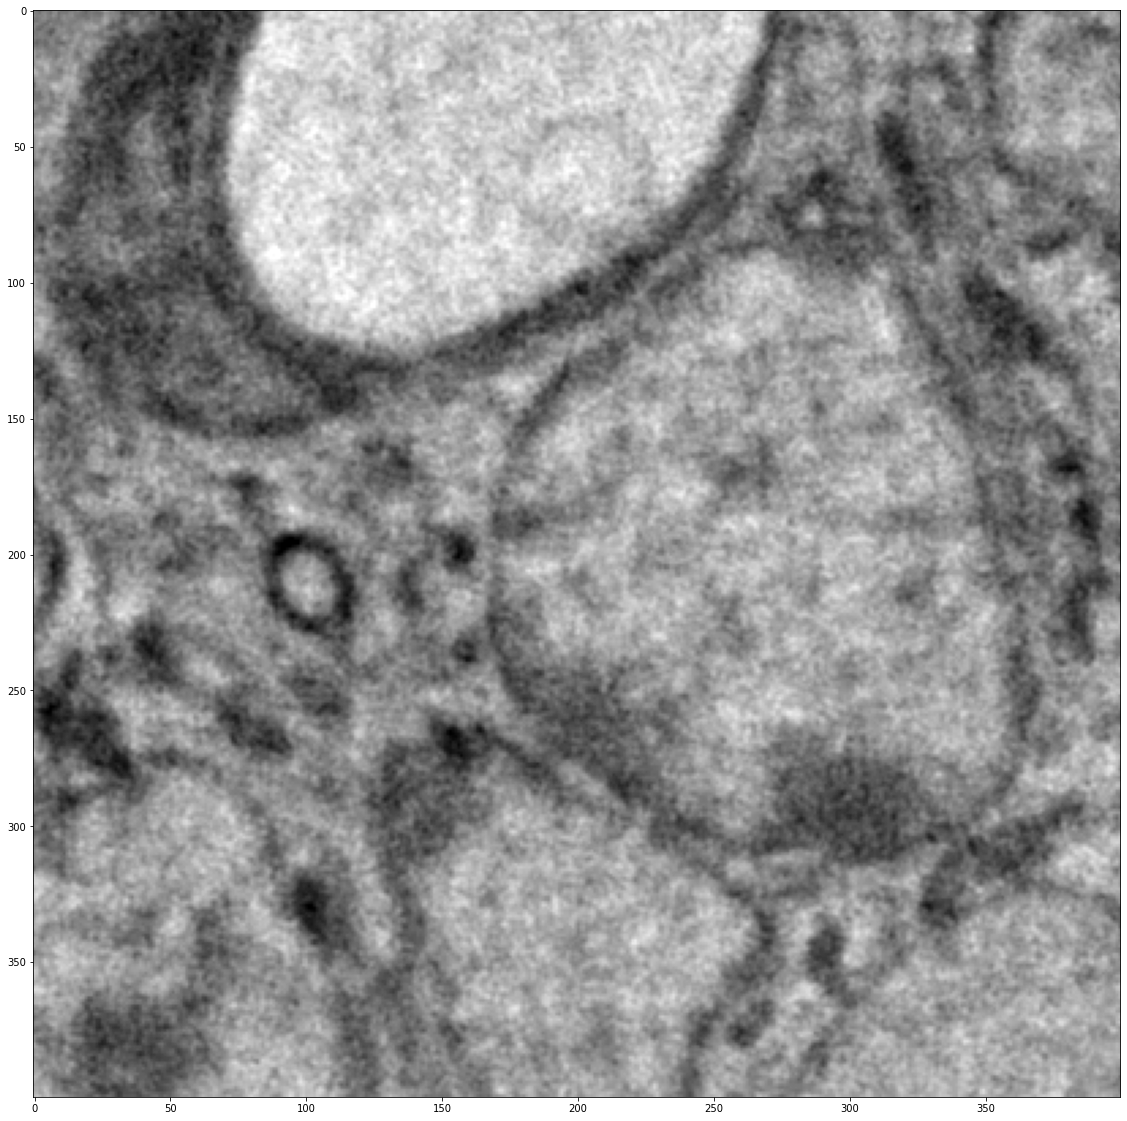

In [24]:
plt.figure(figsize=(20,20))
plt.imshow(im, cmap='gray')

# VALIDATION:

In [1]:
import sys
sys.path.append('/n/groups/htem/users/jlr54/raygun/')
from CycleGAN import *

working_path = '/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/raygun/CycleGAN/'
src_A_path = '/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/jlr54_tests/volumes/CBm_FN_lobX_90nm_tile2_rec_db9_twopass_full_.n5'
src_B_path = '/n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/jlr54_tests/volumes/CBxs_lobX_bottomp100um_30nm_rec_db9_.n5'
model_name = 'CycleGun_CBxFN90nmtile3_CBx30nmBottom100um_20210930'

print('Loading model...')
cycleGun = CycleGAN(src_A=src_A_path, #EXPECTS ZARR VOLUME
                src_B=src_B_path,
                voxel_size=gp.Coordinate((30, 30, 30)), #voxel_size of B
                AB_voxel_ratio=3, #determines whether to add up/downsampling node (always rendered to B's voxel_size), (int or tuple of ints)
                A_name='volumes/raw',
                B_name='volumes/raw',
                # mask_A_name='volumes/masks/train_mask_20210925', # expects mask to be in same place as real zarr
                # mask_B_name='volumes/masks/train_mask_20210925',
                g_init_learning_rate=0.0004,
                d_init_learning_rate=0.0004,
                model_name = model_name,
                model_path = working_path+'models/',
                tensorboard_path = working_path+'tensorboard/'+model_name,
                num_epochs = 20000,
                )                

Loading model...
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal


In [2]:
cycleGun.set_device(3)

INFO:gunpowder.torch.nodes.train:Resuming training from iteration 60000
INFO:gunpowder.torch.nodes.train:Loading /n/groups/htem/ESRF_id16a/tomo_ML/ResolutionEnhancement/raygun/CycleGAN/models/CycleGun_CBxFN90nmtile3_CBx30nmBottom100um_20210930_checkpoint_60000
INFO:gunpowder.torch.nodes.train:Using device cuda
INFO:gunpowder.nodes.generic_train:Train process: iteration=60001 loss=10.184431 time=4.000460


{'loss_D1': 0.21191750466823578, 'loss_D2': 0.07280290871858597, 'loss_cycle': 1.9644191265106201, 'loss_G1': 3.08331561088562, 'loss_G2': 4.851975917816162}



	REAL_A: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: True, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False
	FAKE_A: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: False, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False
	CYCLED_A: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: False, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False
	REAL_B: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: True, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False
	FAKE_B: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: False, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False
	CYCLED_B: ROI: [0:2880, 0:2880, 0:2880] (2880, 2880, 2880), voxel size: (30, 30, 30), interpolatable: F

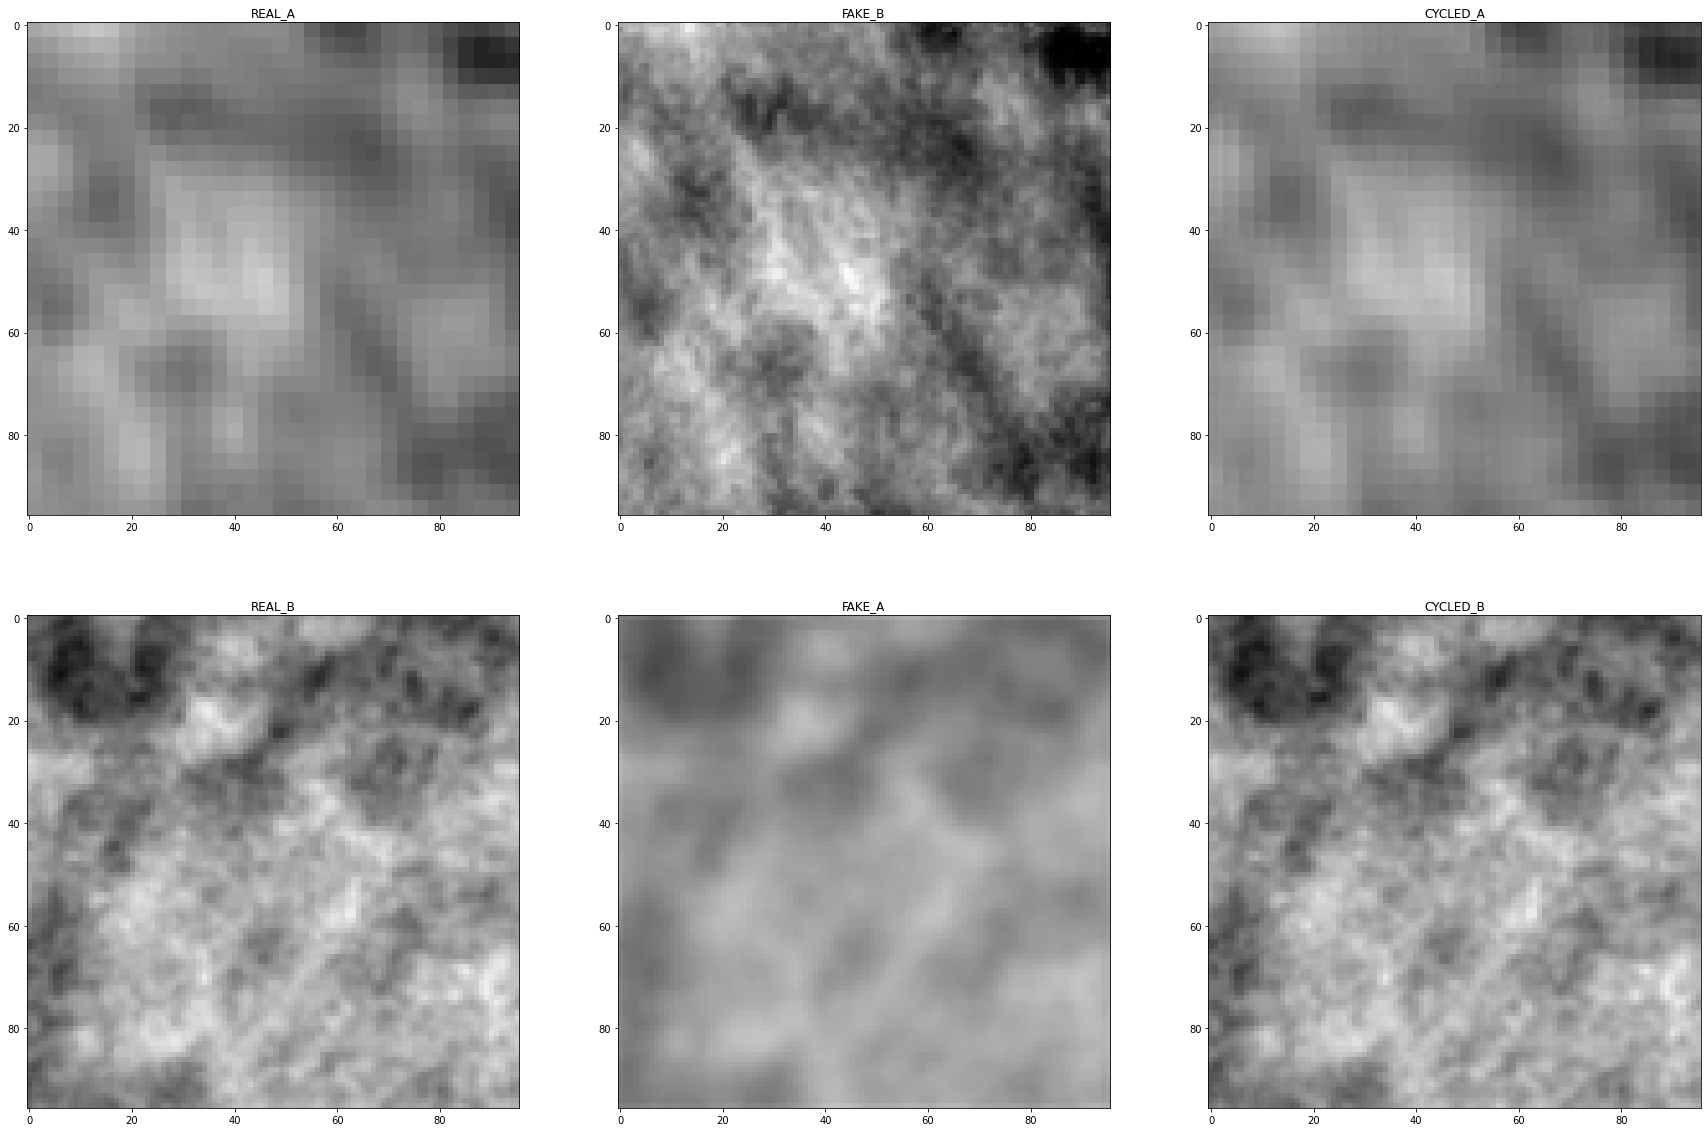

In [3]:
cycleGun.test_train()

INFO:gunpowder.torch.nodes.predict:Predicting on gpu



	REAL_A: ROI: [0:7200, 0:7200, 0:7200] (7200, 7200, 7200), voxel size: (30, 30, 30), interpolatable: True, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False
	FAKE_B: ROI: [0:7200, 0:7200, 0:7200] (7200, 7200, 7200), voxel size: (30, 30, 30), interpolatable: False, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False
	CYCLED_A: ROI: [0:7200, 0:7200, 0:7200] (7200, 7200, 7200), voxel size: (30, 30, 30), interpolatable: False, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False

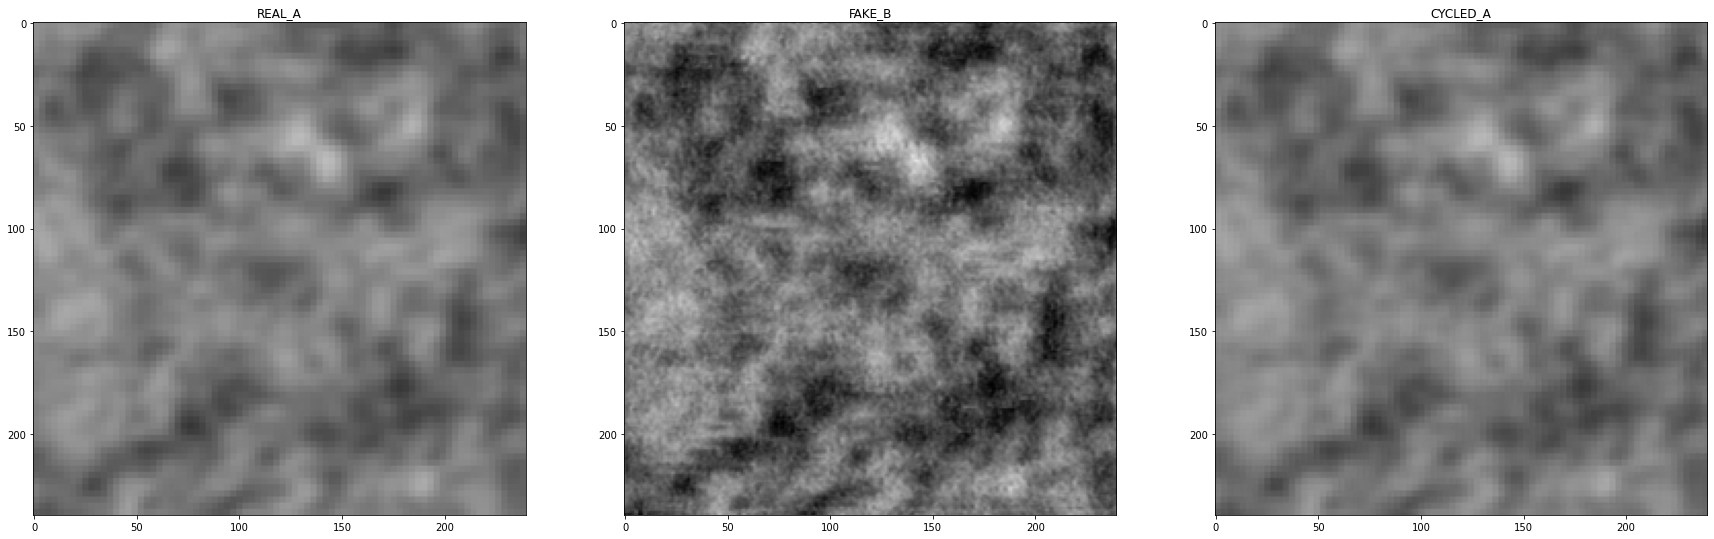

In [17]:
cycleGun.test_prediction(in_type='A', side_length=80)

INFO:gunpowder.torch.nodes.predict:Predicting on gpu



	REAL_B: ROI: [0:7200, 0:7200, 0:7200] (7200, 7200, 7200), voxel size: (30, 30, 30), interpolatable: True, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False
	FAKE_A: ROI: [0:7200, 0:7200, 0:7200] (7200, 7200, 7200), voxel size: (30, 30, 30), interpolatable: False, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False
	CYCLED_B: ROI: [0:7200, 0:7200, 0:7200] (7200, 7200, 7200), voxel size: (30, 30, 30), interpolatable: False, non-spatial: False, dtype: <class 'numpy.float32'>, placeholder: False

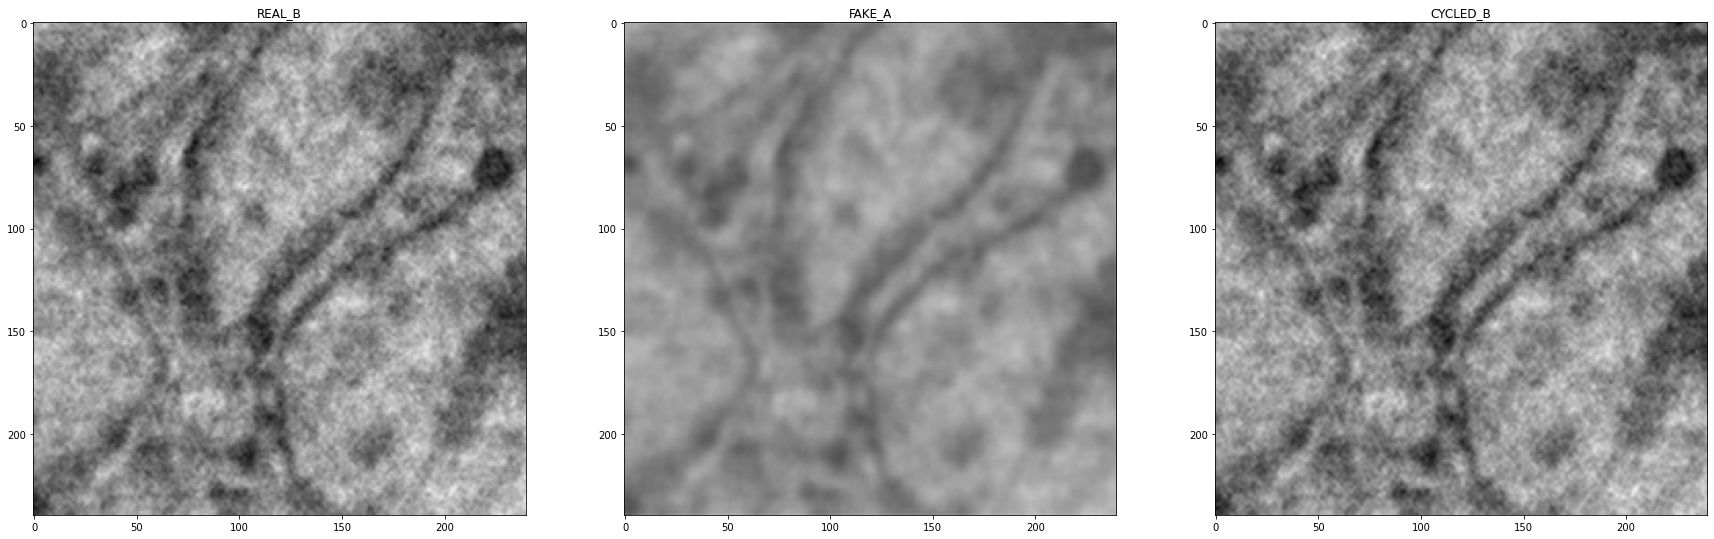

In [6]:
cycleGun.test_prediction(in_type='B', side_length=80)